In [2]:
import numpy as np
import matplotlib.pyplot as plt

from utils import *

from hcipy import *
# from Keck_aperture import *

%load_ext autoreload
%autoreload 2

# Telescope Setup

We'll start with the Magellan pupil (scaled to 3.048m) until we get a desctription of the Shane Pupil

In [3]:
pupil_diameter = 3.048 # m
collecting_area = np.pi*(3.048**2-0.9779**2)
f_number = 13 #Effective focal ratio
effective_focal_length = pupil_diameter*f_number # m

filter_name = 'V'
wavelength = filters[filter_name]['lambda_eff']*1e-6

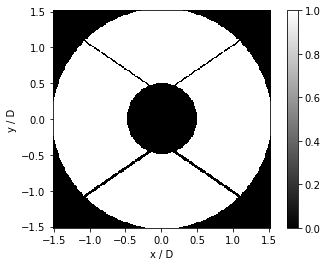

In [4]:
grid_size=256

pupil_grid = make_pupil_grid(grid_size,diameter = pupil_diameter)

#Currently the spiders here do not represent 
telescope_pupil_generator = make_lick_aperture()
telescope_pupil = telescope_pupil_generator(pupil_grid)


im = imshow_field(telescope_pupil, cmap='gray')
plt.colorbar()
plt.xlabel('x / D')
plt.ylabel('y / D')
plt.show()

## Set up the atmosphere

In [5]:
seeing = 1.75 # Estimating this by eye from here: https://mthamilton.ucolick.org/techdocs/MH_weather/obstats/avg_seeing.html
outer_scale = 40 # meter - GUESS NEEDS TO BE REFINED
velocity = 20 # m/s - GUESS NEDS TO BE REFINED

fried_parameter = seeing_to_fried_parameter(seeing,500e-9)
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, 500e-9)
tau0 = 0.314 * fried_parameter/velocity


print('r0   = {0:.1f}cm'.format(fried_parameter * 100))
print('L0   = {0:.1f}m'.format(outer_scale))
print('tau0 = {0:.1f}ms'.format(tau0 * 1000))
print('v    = {0:.1f}m/s'.format(velocity))

r0   = 5.8cm
L0   = 40.0m
tau0 = 0.9ms
v    = 20.0m/s


In [6]:
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)

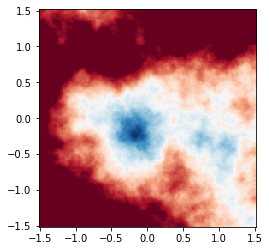

In [7]:
phase_screen_phase = layer.phase_for(wavelength) # in radian
phase_screen_opd = phase_screen_phase * (wavelength / (2 * np.pi)) * 1e6

imshow_field(phase_screen_opd, vmin=-2*np.pi,  cmap='RdBu')

# Now propagate to the focal plane

In [11]:
nairy = 100
focal_grid = make_focal_grid(q=4, 
                             num_airy=nairy,
                            pupil_diameter=pupil_diameter,
                            focal_length=effective_focal_length,
                            reference_wavelength=wavelength,
                            )

prop = FraunhoferPropagator(pupil_grid,focal_grid,
                           focal_length=effective_focal_length)

# focal_image = prop.forward(wavefront)
# focal_image = prop((layer(pupil_wavefront)))

# plt.figure(figsize=(10,8))
# imshow_field((focal_image.intensity / focal_image.intensity.max()))
#plt.xlabel('Focal plane distance [$\lambda/D$]')
#plt.ylabel('Focal plane distance [$\lambda/D$]')
#plt.colorbar()
#plt.show()

## Pick some target properties

In [12]:
mag = 17 #Vega magnitude in the band of interest
stokes_vector= [1,0,0,0.]
exposure_time = 0.01 #exposure time in seconds

pupil_wavefront = Wavefront(telescope_pupil, wavelength,input_stokes_vector=stokes_vector)
pupil_wavefront.total_power = number_of_photons(mag,filter_name,collecting_area,) #In photons/s
print(filters[filter_name]['delta_lambda'])
print(collecting_area,number_of_photons(mag,filter_name,collecting_area,))

0.085
26.182082152446807 35112.71175327789


## Add a companion

In [13]:
contrast = 0.
stokes_ps = [1,0.,0.,0.] #these are I, Q, U, V
angular_separation= 2 #Lambda/D
wf_planet = Wavefront(telescope_pupil*np.exp(4j*np.pi*pupil_grid.x*angular_separation/pupil_diameter),wavelength,
                     input_stokes_vector=stokes_ps)
wf_planet.total_power = number_of_photons(mag,filter_name,collecting_area,)*contrast #In photons/s

17


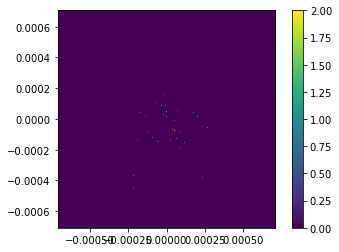

In [18]:
pupil_wavefront = Wavefront(telescope_pupil, wavelength,input_stokes_vector=stokes_vector)
pupil_wavefront.total_power = number_of_photons(mag,filter_name,collecting_area,) #In photons/s
print(mag)
detector = NoisyDetector(focal_grid, dark_current_rate=0, read_noise=0, flat_field=0, include_photon_noise=True)

layer.t = 0.1
for i in range(100):
    layer.t+=exposure_time
    
    #image_comb = prop((layer(pupil_wavefront))).intensity+prop((layer(wf_planet))).intensity*contrast
    #image_star = prop((layer(pupil_wavefront))).intensity

    #intensity = prop((layer(pupil_wavefront))).intensity+prop((layer(wf_planet))).intensity
    detector.integrate(prop((layer(pupil_wavefront))),exposure_time)
    detector.integrate(prop((layer(wf_planet))),exposure_time)
    image_comb = detector.read_out()
#     print(np.max(image_comb))
    npix = int(np.sqrt(len(image_comb)))
    im_ft = image_comb.reshape([npix,npix])

    if i == 0: sg = supergauss_hw(100,4, npix)
    #plt.imshow((im_ft*sg)**0.1)
    #plt.show()
    #stop
    
    FT = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(im_ft*sg)))
    PS = np.abs(FT/FT[int(npix/2),int(npix/2)])**2
    
    if i==0:
        PS_all = np.array(PS)
    else:
        PS_all+=PS
imshow_field(image_comb)
plt.colorbar()
plt.show()
    
###divide PS by azimuthal average at low frequencies (f < 0.2 fc = 0.2 D / lambda)
ACF = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(PS_all)))

99.99999999999999


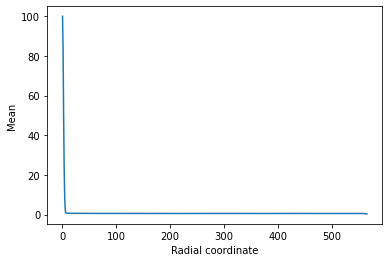

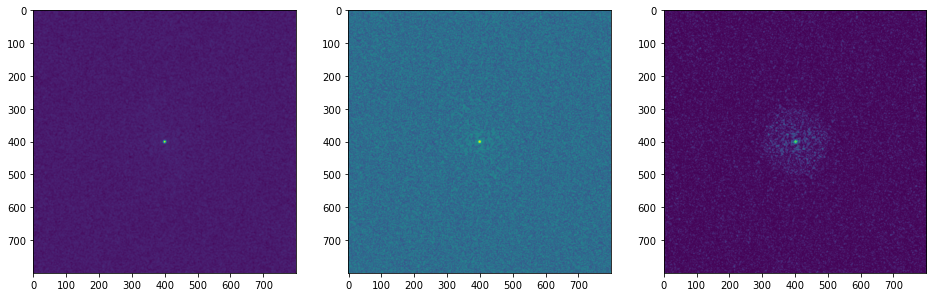

In [15]:
###do bias sub
PS_all_bsub = PS_all.copy()
PS_all_bsub -= np.mean(PS_all[700:,700:])

###divide PS by azimuthal average at low frequencies (f < 0.2 fc = 0.2 D / lambda)
from radial_profile import radial_data

rad_stats = radial_data(PS_all)
plt.figure()
plt.plot(rad_stats.r, rad_stats.mean)
plt.xlabel('Radial coordinate')
plt.ylabel('Mean')

plate_scale = 0.25 * 550. * 10**-9 / pupil_diameter * 206265   ###plate scale of image in arcsec / pixel
###grid is 800 pixels across, equalling 200 lambda / D, plate scale is then 0.25*lambda / D per pixel

ps_mpp = 1. / (npix * plate_scale) * 206265. * 550. * 10**-9 ##pate scale of FT in meters per pixel
scaling = 0.5
fcut = pupil_diameter / ps_mpp * scaling
print(fcut)


PS_all_filt = PS_all_bsub.copy()
for xx in range(len(PS_all_filt)):
    for yy in range(len(PS_all_filt)):
        rad = np.sqrt((xx-npix/2)**2+(yy-npix/2)**2)
        if rad < fcut:
            drad = rad_stats.r-rad
            val = rad_stats.mean[np.where(np.abs(drad)==np.min(np.abs(drad)))][0]
            PS_all_filt[yy,xx]/=val
        
f = plt.figure(figsize=(16,10))
f.add_subplot(131)
plt.imshow(np.abs(PS_all)**0.1)
f.add_subplot(132)
plt.imshow(np.abs(PS_all_bsub)**0.1)
f.add_subplot(133)
plt.imshow(np.abs(PS_all_filt))
plt.show()

ACF_filt = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(PS_all_filt)))
ACF_filt_norm = ACF_filt / ACF_filt[int(npix/2),int(npix/2)]
#ACF_filt_norm_5 = ACF_filt_norm.copy()
#ACF_filt_norm_10 = ACF_filt_norm.copy()
ACF_filt_norm_15 = ACF_filt_norm.copy()

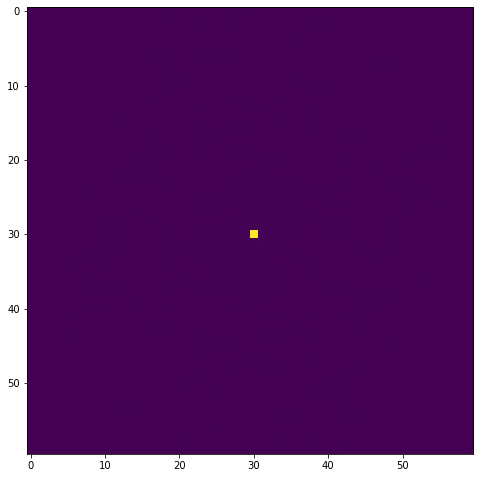

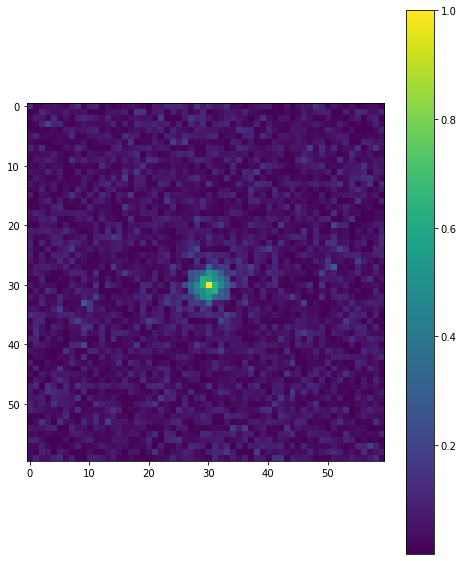

In [16]:
fsub = 30
f = plt.figure(figsize=(8,10))
plt.imshow(np.abs(ACF)[int(npix/2)-fsub:int(npix/2)+fsub,int(npix/2)-fsub:int(npix/2)+fsub])
plt.show()

f = plt.figure(figsize=(8,10))
plt.imshow(np.abs(ACF_filt_norm)[int(npix/2)-fsub:int(npix/2)+fsub,int(npix/2)-fsub:int(npix/2)+fsub])
plt.colorbar()
plt.show()

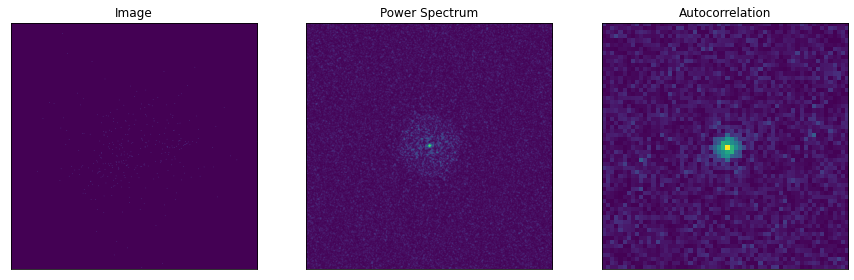

In [17]:
f = plt.figure(figsize=(15,5))
ax=f.add_subplot(131)
plt.imshow(im_ft**0.5)
ax.set_yticks([])
ax.set_xticks([])
plt.title('Image')
ax = f.add_subplot(132)
plt.title('Power Spectrum')
plt.imshow(np.abs(PS_all_filt))
ax.set_yticks([])
ax.set_xticks([])
ax=f.add_subplot(133)
plt.imshow(np.abs(ACF_filt_norm)[int(npix/2)-fsub:int(npix/2)+fsub,int(npix/2)-fsub:int(npix/2)+fsub])
ax.set_yticks([])
ax.set_xticks([])
plt.title('Autocorrelation')
plt.savefig('speckle_imaging.png')
plt.show()

In [14]:
def ACF_cc(ACF):
    return -2.5*np.log10((1-np.sqrt(1-(2*ACF)**2))/(2*ACF))

In [15]:
ACF_m = ACF_cc(ACF_filt_norm)

#f = plt.figure(figsize=(8,10))
#plt.imshow(np.abs(ACF_m)[int(npix/2)-fsub:int(npix/2)+fsub,int(npix/2)-fsub:int(npix/2)+fsub])
#plt.colorbar()
#plt.show()

rad_ACF_5 = radial_data(np.abs(ACF_filt_norm_5),annulus_width=2)
rad_ACF_10 = radial_data(np.abs(ACF_filt_norm_10),annulus_width=2)
rad_ACF_15 = radial_data(np.abs(ACF_filt_norm_15),annulus_width=2)

cc_5 = ACF_cc(5*rad_ACF_5.std)
cc_10 = ACF_cc(5*rad_ACF_10.std)
cc_15 = ACF_cc(5*rad_ACF_15.std)

xax = np.array(range(len(rad_ACF.mean))) * plate_scale / ((550. * 10**-9) / pupil_diameter * 206265) #in lambda/D units
#xax = np.array(range(len(rad_ACF.std))) * plate_scale
f = plt.figure(figsize=(5,4))
plt.plot(xax,cc_5,label='V = 5 mag',lw=3)
#plt.plot(xax,cc_10,label='V = 15 mag',lw=2)
#plt.plot(xax,cc_15,label='V = 17 mag',lw=1)
plt.xlim(0.0,20.0)
plt.gca().invert_yaxis()
plt.legend(loc='lower left')
plt.ylabel(r'5$\sigma$ Contrast (mag)')
plt.xlabel(r'Separation ($\lambda$ / D)')
plt.title('VIPER Conventional Speckle: 100 x 10ms')
plt.savefig('speckle_cont_conv_2.png',dpi=300)
plt.show()

NameError: name 'ACF_filt_norm_5' is not defined

# Speckle polarimetry analysis

In [ ]:
def R_U(f_L,f_R,N_e,theta,h):
    #f_L: left side FTs (numpy array of images)
    #f_R: right side FTs (numpy array of images)
    #rho_L: phase slope for left side
    #rho_R: phase slope for right side
    #fs: spatial frequencies that go with FTs
    #N_e: avg number of photons in a single frame
    #theta: HWP angle (measured in deg)
    #T = np.exp(2.0*np.pi*1.0j*fs*(rho_R - rho_L))
    thetas = np.ones(f_L.shape)
    for x in range(len(thetas)):
        thetas[x] = thetas[x]*theta[x]
    num=np.mean((f_L - f_R)*(f_L + f_R).conj()*np.sin(h*np.radians(thetas)),axis=0)
    den=np.mean((f_L + f_R)*(f_L + f_R).conj(),axis=0) - 1.0/N_e
    R_U = 1 + num/den
    return(R_U)

def R_Q(f_L,f_R,N_e,theta,h):
    #f_L: left side FTs (numpy array of images)
    #f_R: right side FTs (numpy array of images)
    #rho_L: phase slope for left side
    #rho_R: phase slope for right side
    #fs: spatial frequencies that go with FTs
    #N_e: avg number of photons in a single frame
    #theta: HWP angle (measured in deg)
    
    #T = np.exp(2.0*np.pi*1.0j*fs*(rho_R - rho_L))
    #num=np.mean((T*f_L - f_R)*(T*f_L + f_R).conj()*np.cos(h*np.radians(theta)),axis=0)
    #den=np.mean((T*f_L + f_R)*(T*f_L + f_R).conj(),axis=0) - 1.0/N_e
    thetas = np.ones(f_L.shape)
    for x in range(len(thetas)):
        thetas[x] = thetas[x]*theta[x]
    num=np.mean((f_L - f_R)*(f_L + f_R).conj()*np.cos(h*np.radians(thetas)),axis=0)
    den=np.mean((f_L + f_R)*(f_L + f_R).conj(),axis=0) - 1.0/N_e
    R_Q = 1 + num/den
    return(R_Q)


## Calculate FTs for ordinary and extraordinary beams

In [ ]:
#HWP_positions = [0, 45, 22.5, 67.5] # degrees
HWP_positions = np.linspace(0.0,350.0,360)
ims_o = []
ims_e = []


####primary parameters
mag = 5 #Vega magnitude in the band of interest
stokes_vector= [1,0,0,0.]
exposure_time = 0.01 #exposure time in seconds

####companion parameters
contrast = 0.9
stokes_ps = [1,0.3,0.,0.] #these are I, Q, U, V
angular_separation= 10 #Lambda/D
wf_planet = Wavefront(telescope_pupil*np.exp(4j*np.pi*pupil_grid.x*angular_separation/pupil_diameter),wavelength,
                     input_stokes_vector=stokes_ps)
wf_planet.total_power = contrast*number_of_photons(mag,filter_name,collecting_area,)
pupil_wavefront = Wavefront(telescope_pupil, wavelength,input_stokes_vector=stokes_vector)
pupil_wavefront.total_power = number_of_photons(mag,filter_name,collecting_area,) #In photons/s
detector_o = NoisyDetector(focal_grid, dark_current_rate=0, read_noise=0, flat_field=0, include_photon_noise=True)
detector_e = NoisyDetector(focal_grid, dark_current_rate=0, read_noise=0, flat_field=0, include_photon_noise=True)


layer.t = 0.1
wollaston = LinearPolarizingBeamSplitter(0)
for i in range(10):
    layer.t+=exposure_time
    angle = HWP_positions[i]
    HWP = HalfWavePlate(angle)

    star_o, star_e = wollaston(prop(HWP.forward(layer(pupil_wavefront))))
    planet_o, planet_e = wollaston(prop(HWP.forward(layer(wf_planet))))

    detector_o.integrate(star_o,exposure_time)
    detector_o.integrate(planet_o,exposure_time)
    detector_e.integrate(star_e,exposure_time)
    detector_e.integrate(planet_e,exposure_time)

    im_o = detector_o.read_out()
    im_e = detector_e.read_out()
    
    ims_o.append(im_o)
    ims_e.append(im_e)

fig,axes = plt.subplots(1,3,figsize=(20,5))
im0 = imshow_field((im_o),ax=axes[0])
im1=imshow_field((im_e),ax=axes[1])
im2=imshow_field((im_o-im_e),ax=axes[2],cmap='RdBu')

axes[0].set_title("Ordinary Beam")
axes[1].set_title("Extraordinary Beam")
axes[2].set_title("Difference")

plt.colorbar(im0, ax=axes[0])
plt.colorbar(im1, ax=axes[1])
plt.colorbar(im2, ax=axes[2])

In [ ]:
npix = np.prod(im_o.shape)

im_o_fts = []
im_e_fts = []

for i in range(len(ims_o)):
    im_o = ims_o[i]
    im_e = ims_e[i]
    im_o_ft = im_o.copy().reshape([int(np.sqrt(npix)),int(np.sqrt(npix))])
    im_e_ft = im_e.copy().reshape([int(np.sqrt(npix)),int(np.sqrt(npix))])


    from utils import supergauss_hw

    sg = supergauss_hw(100,4, int(np.sqrt(npix)))


    ###background subtraction
    #im_o_ft -= np.median(im_o_ft[1000:,1000:])
    #im_e_ft -= np.median(im_e_ft[1000:,1000:])



    FT_o = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(im_o_ft*sg)))
    FT_e = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(im_e_ft*sg)))
    
    im_o_fts.append(FT_o/FT_o[int(np.sqrt(npix)/2),int(np.sqrt(npix)/2)])
    im_e_fts.append(FT_e/FT_e[int(np.sqrt(npix)/2),int(np.sqrt(npix)/2)])
    
    
    
f = plt.figure(figsize=(10,5))
f.add_subplot(121)
plt.imshow(np.abs(im_o_ft)**0.1)
plt.colorbar()
f.add_subplot(122)
plt.imshow(np.abs(im_e_ft)**0.1)
plt.colorbar()
plt.show()
    
f = plt.figure(figsize=(10,5))
f.add_subplot(121)
plt.imshow(np.abs(im_o_ft*sg)**0.1)
plt.colorbar()
f.add_subplot(122)
plt.imshow(np.abs(im_e_ft*sg)**0.1)
plt.colorbar()
plt.show()
    
f = plt.figure(figsize=(10,5))
f.add_subplot(121)
plt.imshow(np.abs(FT_o)**0.1)
plt.colorbar()
f.add_subplot(122)
plt.imshow(np.abs(FT_e)**0.1)
plt.colorbar()
plt.show()

In [ ]:
#determine average FTs and approximate phase as constant slope

#for now, assume rho_L and rho_R are 0
rho_L = 0
rho_R = 0
fs_y = np.fft.fftshift(np.fft.fftfreq(len(im_o_ft)))
fs_x = np.fft.fftshift(np.fft.fftfreq(len(im_o_ft[0])))
N_e = np.mean([ims_o,ims_e])
print(N_e)

hwps = np.array(HWP_positions)
harmonic = 4.0

Ru = R_U(np.array(im_o_fts),np.array(im_e_fts),N_e,hwps,harmonic)
Rq = R_Q(np.array(im_o_fts),np.array(im_e_fts),N_e,hwps,harmonic)

In [ ]:
f = plt.figure(figsize=(16,16))
f.add_subplot(221)
plt.imshow(np.abs(Rq))
plt.title('|R_Q|')
plt.colorbar()
f.add_subplot(222)
plt.imshow(np.angle(Rq))
plt.title('Arg(R_Q)')
plt.colorbar()
f.add_subplot(223)
plt.imshow(np.abs(Ru))
plt.title('|R_U|')
plt.colorbar()
f.add_subplot(224)
plt.imshow(np.angle(Ru))
plt.title('Arg(R_U)')
plt.colorbar()
plt.show()


In [ ]:
IFT_Q = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(Rq-1.0)))
f = plt.figure(figsize=(10,8))
plt.imshow(np.abs(IFT_Q))
plt.show()

IFT_U = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(Ru-1.0)))
f = plt.figure(figsize=(10,8))
plt.imshow(np.abs(IFT_U))
plt.show()
stop

In [ ]:
PI = IFT_Q + IFT_U
rad_PI = radial_data(np.abs(PI),annulus_width=2)
plt.plot(range(len(rad_PI.std)),-2.5*np.log10(rad_PI.max))
plt.show()


## Polarized companion

In [ ]:
contrast = 1e-1
stokes_ps = [1,0.3,0.,0.] #these are I, Q, U, V
angular_separation= 2 #Lambda/D
wf_planet = Wavefront(telescope_pupil*np.exp(2j*np.pi*pupil_grid.x*angular_separation/pupil_diameter),wavelength,
                     input_stokes_vector=stokes_ps)
wf_planet.total_power = contrast*number_of_photons(mag,filter_name,collecting_area,)

## Polarimeter Setup
Our basic polarimeter will have a half-wave plate and a wollaston

In [ ]:
HWP = HalfWavePlate(0)

# We'll integrate HWP positions later
# HWP_positions = [0, 45, 22.5, 67.5] # degrees

# The wollaston creates two beams: the ordinary ('o') and extraordinary ('e') beams
# We generate fields for both beams for both the planet and star
wollaston = LinearPolarizingBeamSplitter(0)
star_o, star_e = wollaston(prop(HWP.forward(layer(pupil_wavefront))))
planet_o, planet_e = wollaston(prop(HWP.forward(layer(wf_planet))))

tores = int(np.sqrt(len(star_o.power)))
science1 = (star_o.power + planet_o.power).reshape(tores,tores)
science2 = (star_e.power + planet_e.power).reshape(tores,tores)


f = plt.figure(figsize=(15,4))
f.add_subplot(131)
plt.imshow(science1)
f.add_subplot(132)
plt.imshow(science2)
f.add_subplot(133)
plt.imshow(science1-science2)
plt.show()


print(planet_o)
print(focal_grid)
#We need a detector for each beam 
detector_o = NoisyDetector(focal_grid, dark_current_rate=0, read_noise=1, flat_field=0, include_photon_noise=True)
detector_e = NoisyDetector(focal_grid, dark_current_rate=0, read_noise=1, flat_field=0, include_photon_noise=True)

In [ ]:
# Get the power at each beam, combining the star and planet
print(exposure_time)
#Get the power at each beam, combining the star and planet
detector_o.intensity = star_o.power + planet_o.power ##
detector_e.intensity = star_e.power + planet_e.power

detector_o.integrate(detector_o.intensity,exposure_time)
detector_e.integrate(detector_e.intensity,exposure_time)

## Read out the detectors

In [ ]:
im_o = detector_o.read_out()
im_e = detector_e.read_out()

Plot it up!

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(20,5))
im0 = imshow_field((im_o),ax=axes[0])
im1=imshow_field((im_e),ax=axes[1])
im2=imshow_field((im_o-im_e),ax=axes[2],cmap='RdBu')

axes[0].set_title("Ordinary Beam")
axes[1].set_title("Extraordinary Beam")
axes[2].set_title("Difference")

plt.colorbar(im0, ax=axes[0])
plt.colorbar(im1, ax=axes[1])
plt.colorbar(im2, ax=axes[2])

# We could also consider a noiseless detector

Set up the Detector

In [ ]:
detector_o = NoiselessDetector(focal_grid)
detector_e = NoiselessDetector(focal_grid)

#Get the power at each beam, combining the star and planet
detector_o.intensity = star_o.power + planet_o.power ##
detector_e.intensity = star_e.power + planet_e.power

detector_o.integrate(detector_o.intensity,exposure_time)
detector_e.integrate(detector_e.intensity,exposure_time)
im_o = detector_o.read_out()
im_e = detector_e.read_out()

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(20,5))
im0 = imshow_field((im_o),ax=axes[0])
im1=imshow_field((im_e),ax=axes[1])
im2=imshow_field((im_o-im_e),ax=axes[2],cmap='RdBu')

axes[0].set_title("Ordinary Beam")
axes[1].set_title("Extraordinary Beam")
axes[2].set_title("Difference")

plt.colorbar(im0, ax=axes[0])
plt.colorbar(im1, ax=axes[1])
plt.colorbar(im2, ax=axes[2])

# We can propagate the atmospheric layer: 

In [ ]:
layer.t = 0.1 # sec #Note this is an absolute time, not relative. 
                    #If we move to t=0.2 and then back to t=0.1, it will be the same

star_o, star_e = wollaston(prop(HWP.forward(layer(pupil_wavefront))))
planet_o, planet_e = wollaston(prop(HWP.forward(layer(wf_planet))))

#Get the power at each beam, combining the star and planet
detector_o.intensity = star_o.power + planet_o.power ##
detector_e.intensity = star_e.power + planet_e.power

detector_o.integrate(detector_o.intensity,exposure_time)
detector_e.integrate(detector_e.intensity,exposure_time)

im_o = detector_o.read_out()
im_e = detector_e.read_out()

fig,axes = plt.subplots(1,3,figsize=(20,5))
im0 = imshow_field((im_o),ax=axes[0])
im1=imshow_field((im_e),ax=axes[1])
im2=imshow_field((im_o-im_e),ax=axes[2],cmap='RdBu')

axes[0].set_title("Ordinary Beam")
axes[1].set_title("Extraordinary Beam")
axes[2].set_title("Difference")

plt.colorbar(im0, ax=axes[0])
plt.colorbar(im1, ax=axes[1])
plt.colorbar(im2, ax=axes[2])

# We can rotate the HWP 
(without moving the atmosphere in this case)

## We can now save the fields: 

In [ ]:
print(np.median(im_o)) #ask Max why this drops from 0.5 to 0.02 if you re-run cell 18 -- hcipy knowledge gap here
save_field_to_fits(im_o,"im_o.fits",verbose=True,overwrite=True)
save_field_to_fits(im_e,"im_e.fits",verbose=True,overwrite=True)

# If we assume all the optics have perfect transmission, how faint can we go in 30ms? 

In [ ]:
mag = 10 #Vega magnitude in the band of interest
filter_name = 'V'
exposure_time = 0.001 #exposure time in seconds
wavelength = filters[filter_name]['lambda_eff']*1e-6
stokes_vector= [1,0,0,0.]

pupil_wavefront = Wavefront(telescope_pupil, wavelength,input_stokes_vector=stokes_vector)
pupil_wavefront.total_power = number_of_photons(mag,filter_name,collecting_area,) #In photons/s
print(pupil_wavefront.total_power)

In [ ]:
# HWP_positions = [0, 45, 22.5, 67.5] # degrees
HWP = HalfWavePlate(45)

star_o, star_e = wollaston(prop(HWP.forward(layer(pupil_wavefront))))

# Get the power at each beam, combining the star and planet
#Get the power at each beam, combining the star and planet
detector_o.intensity = star_o.power*exposure_time
detector_e.intensity = star_e.power*exposure_time

im_o = detector_o.read_out()
im_e = detector_e.read_out()

im_o[im_o < 1] = 0
im_e[im_e < 1] = 0

fig,axes = plt.subplots(1,3,figsize=(20,5))
im0 = imshow_field((im_o),ax=axes[0])
im1=imshow_field((im_e),ax=axes[1])
im2=imshow_field((im_o-im_e),ax=axes[2],cmap='RdBu',vmin=-0.05,vmax=0.05)

axes[0].set_title("Ordinary Beam")
axes[1].set_title("Extraordinary Beam")
axes[2].set_title("Difference")

plt.colorbar(im0, ax=axes[0])
plt.colorbar(im1, ax=axes[1])
plt.colorbar(im2, ax=axes[2])